# Hybrid modelling for time series
Pablo Estrada & Soledad Coppiano (2018)

We make a comparison between traditional time series methods like ARIMA models, and novel approaches like Neural Networks. We propose a study case and emphasize the strenghtes and weaknesses of both methods.

## LSTM neural networks

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

from supervised_ts import series_to_supervised
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Configure visualizations
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = [7,4]

-------------------------


Using TensorFlow backend.


## Quito Store

## Part 0: Load & Preprocess data
The data consists of retail stores' transactions. The stores are from Quito (44) and from Guayaquil (34).

In [2]:
# fix random seed for reproducibility
np.random.seed(42)
# Store to predict transactions
store = 44

We have to normalize the data before put it in the neural network. We are using 2016 and above.

In [3]:
# load the dataset
df_transactions = pd.read_csv(r'..\..\data\input\transaction{}.csv'.format(store), usecols=[0, 2], index_col=0)

# Using 2016 and above
df_transactions.index = df_transactions.index.to_datetime()
df_transactions = df_transactions[df_transactions.index.year>=2016]

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(df_transactions)
df_transactions["transactions"] = scaled_values

# split into train and test sets
y = df_transactions.astype(float)
train_size = int(len(y) * 0.70)
train, test = y[0:train_size], y[train_size:]
print("train: {}, test: {}".format(len(train), len(test)))

train: 411, test: 177


I have to define the max value of lags I need. 

The function series_to_supervised helps me lagging my dependent variable. 

Finally I need to define train-test data.

In [4]:
max_lags = 15
train = series_to_supervised(train, max_lags, 1)
test = series_to_supervised(test, max_lags, 1)

output_list = ["var1(t)"]
xtrain, ytrain = train.iloc[:,:-1], train.loc[:,output_list]
xtest, ytest = test.iloc[:,:-1], test.loc[:,output_list]

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, my data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [5]:
# reshape input to be [samples, time steps, features]
xtrain = xtrain.values
xtest = xtest.values
ytrain = ytrain.values
ytest = ytest.values
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))

## Part 1: Design Network

The network has a visible layer with 1 input, a hidden layer with 50 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 50 epochs and a batch size of 1 is used.

In [6]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(xtrain, ytrain, epochs=50, batch_size=1, validation_data=(xtest, ytest), verbose=0, shuffle=False)

In [127]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

It seems that the loss value converge.

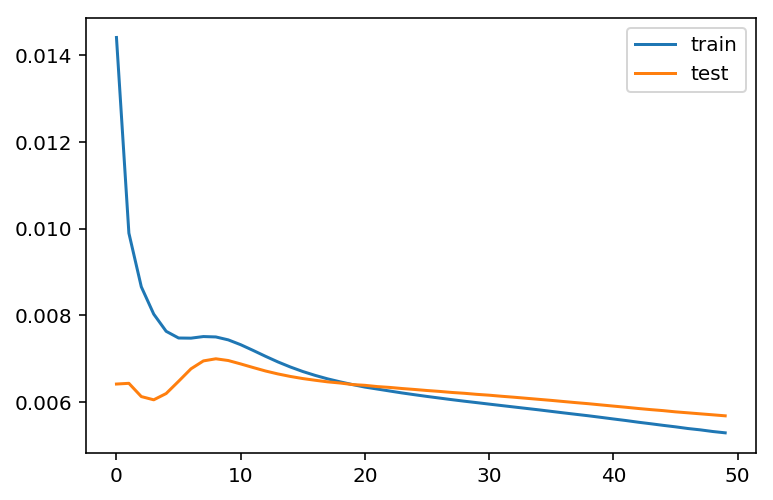

In [7]:
# plot history
# History is a dictionary with dict_keys(['val_loss', 'loss'])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Part 2: Forecasting LSTM

I have to re-scale the values to make comparisons.

In [8]:
yhat = model.predict(xtest)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(y)

y_pred = pd.Series(inv_yhat.reshape(-1), index=df_transactions[train_size+max_lags:].index)
y = pd.Series(inv_y.reshape(-1), index=df_transactions.index)

rmse = np.sqrt(mean_squared_error(y[train_size+max_lags:], y_pred))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 398.86


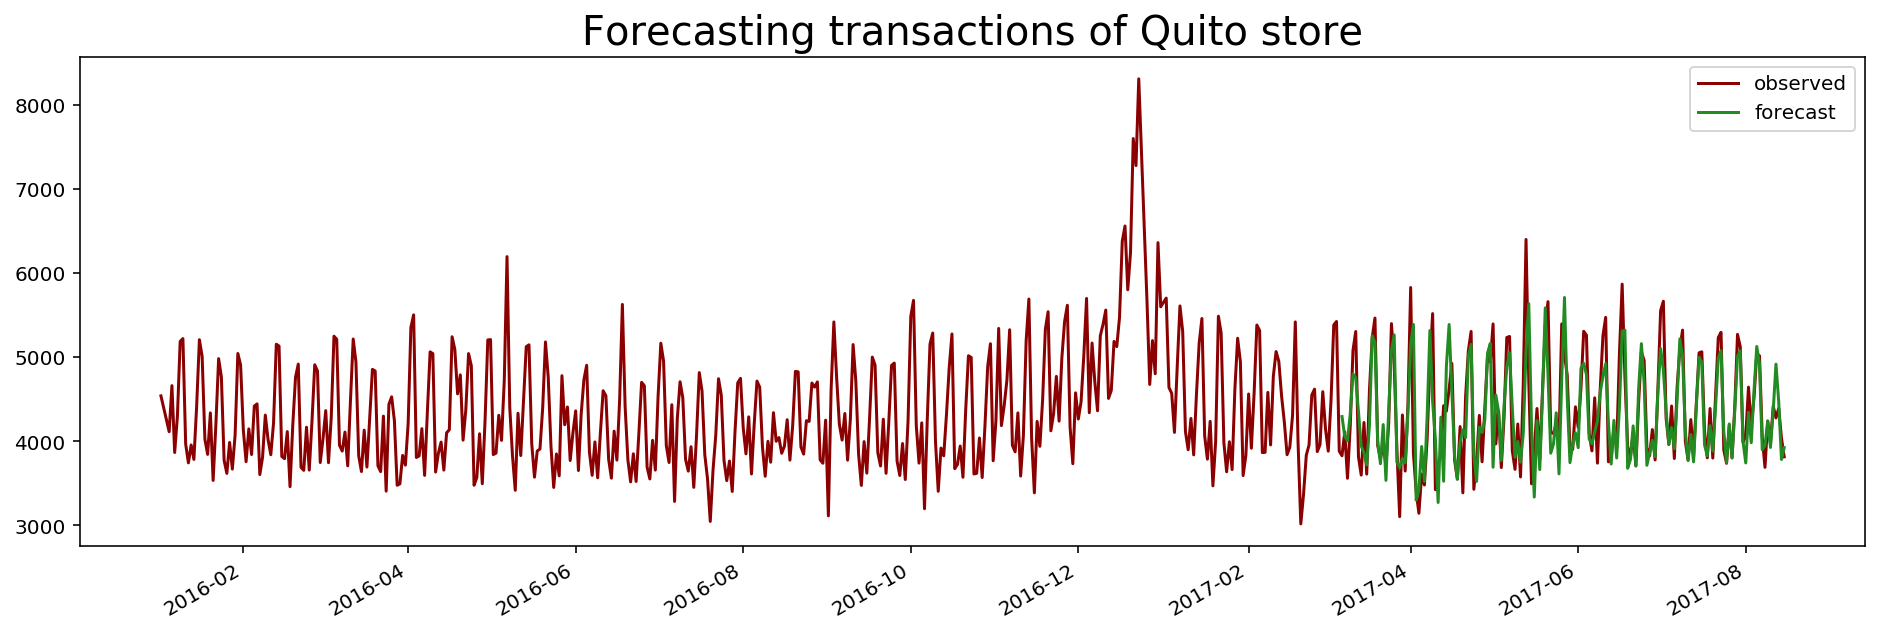

In [9]:
ax = y.plot(label='observed', figsize=(16, 5), color="darkred")
y_pred.plot(ax=ax, label='forecast', color="forestgreen")

plt.title("Forecasting transactions of Quito store", fontsize=20)
plt.legend()
# plt.savefig('../figures/forecast_lstm{}.png'.format(store), dpi=300, bbox_inches='tight')
plt.show()